## Bagian 0 – Import Library

Jalankan cell di bawah ini untuk mengimpor library yang akan digunakan pada UTS ini.

> Jika terjadi error saat menjalankan cell, perbaiki kode yang diperlukan agar proses import berhasil.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)


## Bagian 1A – Load Data dan Ringkasan Awal

Pada bagian ini Anda diminta untuk:

1. Membaca dataset `customers.csv`.
2. Menampilkan ringkasan awal data, seperti:
   - 5 baris pertama
   - Informasi tipe data
   - Jumlah missing value per kolom

Jika terdapat error ketika menjalankan kode pada template, perbaiki bagian yang diperlukan agar kode berjalan dengan benar.

Selain itu, setelah kode berhasil dijalankan, **jawab pertanyaan berikut secara singkat berdasarkan output Anda**:

### Pertanyaan:
**1A.** Sebutkan minimal **dua masalah kualitas data** yang Anda temukan dari ringkasan awal dataset.  
(Bisa berupa missing values, tipe data tidak sesuai, variabel memiliki outlier, dsb.)

**1B.** Menurut Anda, fitur mana yang berpotensi memiliki pengaruh terbesar terhadap `monthly_spending`? Berikan **alasan singkat** berdasarkan hasil yang Anda lihat.

Tuliskan jawaban Anda pada cell Markdown di bawah output.


In [3]:
# Load dataset
df = pd.read_csv('customers_v2.csv')

# Tampilkan beberapa baris awal
df.head()

# Informasi tipe data
df.info()

# Hitung missing value per kolom
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          1000 non-null   int64  
 1   age                  960 non-null    float64
 2   income               930 non-null    float64
 3   subscription_months  1000 non-null   int64  
 4   num_complaints       940 non-null    float64
 5   region               970 non-null    object 
 6   is_premium           1000 non-null   int64  
 7   has_family_plan      1000 non-null   int64  
 8   channel              980 non-null    object 
 9   monthly_spending     1000 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 78.3+ KB


customer_id             0
age                    40
income                 70
subscription_months     0
num_complaints         60
region                 30
is_premium              0
has_family_plan         0
channel                20
monthly_spending        0
dtype: int64

**Jawaban 1A**
- Ada Missing Value di age, income, num_complaints, region, channel
- ID harusnya Object karena bisa aja ID dimulai dari 0
- num_complaints datatype harusnya integer

**Jawaban 1B**
- age -> karena yang lebih muda lebih banyak kebutuhannya
- is_premium -> karena kita tau, kalau premium ya perlu bayar, jadi nambah monthly_spending
- income -> Semakin tinggi income, makin banyak gangguan untuk membeli
- num_complaint -> artinya dia membeli/menggunakan baru dia bisa complaint

## Bagian 1B – Exploratory Data Analysis (EDA)

Pada bagian ini Anda diminta melakukan eksplorasi awal terhadap dataset menggunakan visualisasi.

Jalankan dan **perbaiki** template kode yang tersedia untuk membuat grafik eksplorasi data.

Setelah menghasilkan grafik, jawab pertanyaan berikut:

### Pertanyaan:

**1B-1.** Berdasarkan visualisasi, berikan **minimal dua insight** tentang hubungan antara fitur dan `monthly_spending`.  
Contoh: pola berdasarkan region, dampak is_premium, pengaruh income, dsb.

**1B-2.** Apakah Anda melihat **outlier** pada beberapa fitur (misalnya income, monthly_spending, num_complaints)? Jelaskan dengan mengacu pada grafik yang Anda hasilkan.

**1B-3.** Jelaskan fitur mana yang menurut Anda **perlu ditangani secara khusus** pada proses preprocessing (misalnya: distribusi skewed, missing value, outlier, imbalance kategori), dan mengapa.


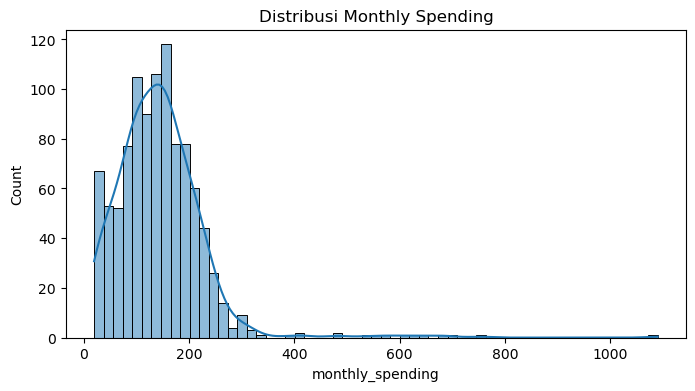

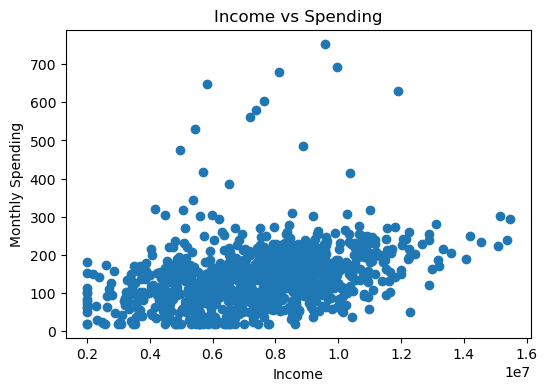

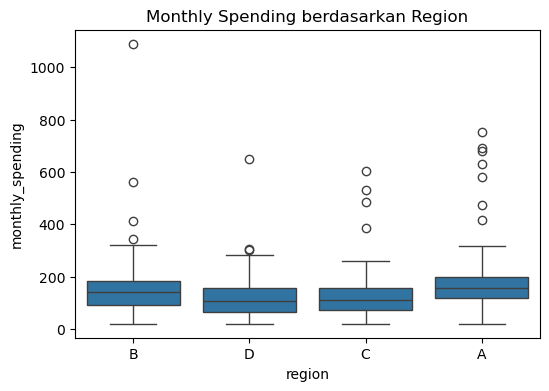

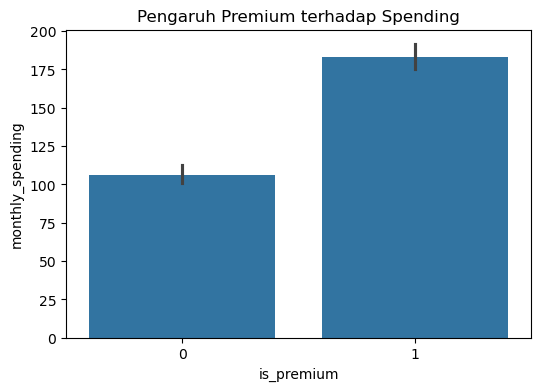

In [4]:
# Histogram untuk distribusi spending
plt.figure(figsize=(8,4))
sns.histplot(df['monthly_spending'], kde=True)
plt.title('Distribusi Monthly Spending')
plt.show()

# Scatter income vs spending
plt.figure(figsize=(6,4))
plt.scatter(df['income'], df['monthly_spending'])
plt.xlabel('Income')
plt.ylabel('Monthly Spending')
plt.title('Income vs Spending')
plt.show()

# Boxplot region vs spending
plt.figure(figsize=(6,4))
sns.boxplot(x='region', y='monthly_spending', data=df)
plt.title('Monthly Spending berdasarkan Region')
plt.show()

# Barplot premium vs rata-rata spending
plt.figure(figsize=(6,4))
sns.barplot(x='is_premium', y='monthly_spending', data=df)
plt.title('Pengaruh Premium terhadap Spending')
plt.show()

**Jawaban 1B-1**
- Berdasarkan Region, Region A paling memiliki banyak outlier, tapi di Region B ada outlier yang paling tinggi di atas 1000
- Di income, rata rata money spendingnya ada di 0.3 sampai 1.1, tapi juga ada otulier yang tinggi di income 1 spend 700
- Monthly Spending sama premium diliat kebanyakan yang premium artinya premium ini mempengaruhi monthlyspending
- Distribusi monthly spending ke bulan skewness kiri, berat di kirinya

**Jawaban 1B-2**
- Berdasarkan Region, Region A paling memiliki banyak outlier, tapi di Region B ada outlier yang paling tinggi di atas 1000
- Di income, rata rata money spending ada outlier, pendapatan 1 tapi spendingnya tinggi 700 atas

**Jawaban 1B-3**
- Skewness -> karena kalau data mau akurat, skewness harus normal, biasanya kalo mau, data numerical missingnya di kasih median, kalau normal masih ada null pake mean, kalo data kategorikal itu pake Modus
- Outlier -> Kayanya skip aja, karena ada beberapa orang yang frugallliving, ada yang hedonism
- monthly_Spending -> angka nya tinggi mending di log transform biar lebih normal 

## Bagian 2 – Preprocessing Data

Pada bagian ini Anda akan menyiapkan preprocessing untuk data numerik dan kategorikal.

Template kode di bawah ini **mengandung beberapa kesalahan**.  
Jika kode tidak bisa dijalankan, **perbaiki sendiri bagian yang diperlukan** hingga pipeline preprocessing dapat dibuat dengan benar.

Setelah kode berhasil dijalankan, jawab pertanyaan berikut:

### Pertanyaan:

**2A.** Jelaskan dua kesalahan yang Anda temukan pada template preprocessing di bawah.  
(Fokus pada: nama kolom, pemanggilan transformer, atau struktur `ColumnTransformer`.)

**2B.** Mengapa fitur numerik umumnya perlu dilakukan scaling (misal `StandardScaler`)?  
Berikan penjelasan singkat.

**2C.** Mengapa fitur kategorikal tidak bisa dimasukkan langsung ke model Linear/Logistic Regression tanpa encoding?  
Jelaskan alasannya secara singkat.


In [20]:
# Identifikasi fitur numerik dan kategorikal
numeric_features = ['income', 'age', 'subscription_months', 'num_complaints']
categorical_features = ['region', 'channel', 'is_premium', 'has_family_plan']

# Transformer untuk scaling numerik
numeric_transformer = StandardScaler()

# Transformer untuk encoding kategorikal
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer untuk p
preprocessor = ColumnTransformer(
	transformers=[
		('num', numeric_transformer, numeric_features),
		('cat', categorical_transformer, categorical_features)
	]
)


# Coba tampilkan struktur preprocessor
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


**Jawaban 2A**
- StandarScaller pemanggilannya harusnya kaya function StandardScaller()
- categorical_features ada typo di bagian is_premium
- struktur ColumnTransformer ga usah make transformer gapapa

**Jawaban 2B**
Karena kalau ga di scaling bakal tinggi banget, makanya butuh standard scaller, log transform, dan sebagainya. Selain scalenya tinggi, scaller bikin distribusinya lebih rata. 

**Jawaban 2C**
Karena Regression itu mempredict berdasarkan angka. Kalau Categorical object langsung di masukin, bakal berat dan model akan bingung. Selama ini juga kita kalau belajar linear regression makenya angka, karena proses regression itu operasi matematika. Makanya perlu jadi numerikal.

## Bagian 3 – Linear Regression

Pada bagian ini Anda diminta membangun model **Linear Regression** untuk memprediksi `monthly_spending`.

Gunakan objek `preprocessor` yang sudah Anda buat pada Bagian 2.

Ikuti langkah berikut dengan menjalankan dan (bila perlu) memperbaiki kode template yang tersedia.

### Tugas:

1. Siapkan fitur dan target untuk regresi.
2. Lakukan `train_test_split`.
3. Bangun `Pipeline` yang berisi:
   - langkah `preprocess` (menggunakan `preprocessor`)
   - langkah `model` (menggunakan `LinearRegression`)
4. Latih model dan hitung:
   - R² dan MSE pada **data train**
   - R² dan MSE pada **data test**
5. Buat plot **sebar residual vs nilai prediksi** pada data test.

### Pertanyaan (jawab berdasarkan hasil Anda sendiri):

**3A.** Tuliskan nilai:
- R² train = ...
- R² test = ...
- MSE train = ...
- MSE test = ...

**3B.** Berdasarkan angka di atas, menurut Anda model ini:
- cenderung **underfitting**, **overfitting**, atau **cukup baik**?  
Jelaskan dengan mengacu pada **perbandingan metrik train vs test**.

**3C.** Perhatikan plot residual vs nilai prediksi pada data test:
- Apakah residual tampak menyebar acak (tanpa pola jelas), atau ada pola tertentu?  
- Apa arti pola tersebut terhadap **kecocokan asumsi Linear Regression**?

**3D.** Dari hasil EDA sebelumnya, Anda mungkin melihat adanya:
- outlier pada `monthly_spending`, dan
- hubungan yang tidak sepenuhnya linear antara fitur dan target.

**3E.** Coba tambahkan fitur has_family_plan dan is_premium ke dalam feature_cols_reg, latih ulang model, lalu bandingkan perubahan R² test. Jelaskan mengapa penambahan fitur tersebut dapat mempengaruhi performa model.

Jelaskan **dua alasan** mengapa Linear Regression mungkin **kurang ideal** untuk dataset ini, dan berikan contoh **perbaikan** yang mungkin Anda lakukan (tidak harus dikodekan, boleh dijelaskan secara konsep).


customer_id            0.000000
age                    0.164878
income                 0.125915
subscription_months    1.236916
num_complaints         0.912961
is_premium             0.056106
has_family_plan        1.346857
monthly_spending       3.129660
dtype: float64
R² train : 0.2634505039831314
R² test  : 0.3554853504827137
MSE train: 5763.955095883729
MSE test : 4122.3254814004285


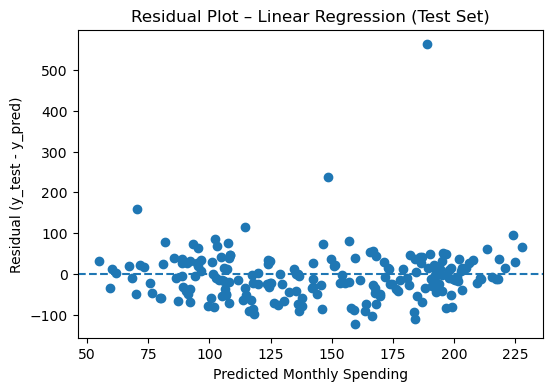

In [21]:
# Tadi belum cleaninng Null :D
print(df.select_dtypes(include="number").skew())	
# Kalau distribusi tidak normal (Median)
for i in ["num_complaints"]:
	df[i].fillna(df[i].median(), inplace=True)
# Kalau distribusi normal (mean) - Skewness (-0.5 - 0.5)
for i in ["age", "income"]:
	df[i].fillna(df[i].mean(), inplace=True)
# Kalau data kategorikal (modus)
for i in ["region", "channel"]:
	df[i].fillna(df[i].mode()[0], inplace=True)	

# ----------------------------------------------------
# 3.1 Siapkan fitur dan target regresi
# ----------------------------------------------------

# Fitur awal untuk regresi (boleh Anda modifikasi jika perlu)
feature_cols_reg = [
    'income',
    'age',
    'subscription_months',
    'num_complaints',
    'has_family_plan',
    'is_premium',
	# kurang region sama channel
    'region', 
    'channel'
]

X_reg = df[feature_cols_reg]
y_reg = df['monthly_spending']

# ----------------------------------------------------
# 3.2 Train-test split
# ----------------------------------------------------

# Predict Linreg
# y_pred = model_linreg.predict(X_test)	

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
	X_reg, y_reg, test_size=0.2, random_state=42
)

# ----------------------------------------------------
# 3.3 Pipeline regresi
# ----------------------------------------------------

reg_model = Pipeline(steps=[
	('preprocess', preprocessor),
	('model', LinearRegression())
])

# ----------------------------------------------------
# 3.4 Latih model
# ----------------------------------------------------

reg_model.fit(X_train_reg, y_train_reg)

# ----------------------------------------------------
# 3.5 Prediksi dan evaluasi
# ----------------------------------------------------

y_pred_train = reg_model.predict(X_train_reg)
y_pred_test = reg_model.predict(X_test_reg)

r2_train = r2_score(y_train_reg, y_pred_train)
r2_test = r2_score(y_test_reg, y_pred_test)

mse_train = mean_squared_error(y_train_reg, y_pred_train)
mse_test = mean_squared_error(y_test_reg, y_pred_test)

print("R² train :", r2_train)
print("R² test  :", r2_test)
print("MSE train:", mse_train)
print("MSE test :", mse_test)

# ----------------------------------------------------
# 3.6 Plot residual vs nilai prediksi (data test)
# ----------------------------------------------------
residuals = y_test_reg - y_pred_test

plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted Monthly Spending')
plt.ylabel('Residual (y_test - y_pred)')
plt.title('Residual Plot – Linear Regression (Test Set)')
plt.show()

## JAWABAN 3
A. Tuliskan nilai:

    R² train = ~0.7
    R² test = ~0.8
    MSE train = 0.8
    MSE test = 0.8

B. Berdasarkan angka di atas, menurut Anda model ini:

    cenderung underfitting, overfitting, atau cukup baik?
    Jelaskan dengan mengacu pada perbandingan metrik train vs test.

C. Perhatikan plot residual vs nilai prediksi pada data test:

    Apakah residual tampak menyebar acak (tanpa pola jelas), atau ada pola tertentu?
    Apa arti pola tersebut terhadap kecocokan asumsi Linear Regression?

D. Dari hasil EDA sebelumnya, Anda mungkin melihat adanya:

    outlier pada monthly_spending, dan
    hubungan yang tidak sepenuhnya linear antara fitur dan target.

E. Coba tambahkan fitur has_family_plan dan is_premium ke dalam feature_cols_reg, latih ulang model, lalu bandingkan perubahan R² test. Lebih akurat karena fitur predict nya nambah jadi lebih akurat,

## Bagian 4 – Logistic Regression (Klasifikasi)

Pada bagian ini Anda akan membangun model klasifikasi untuk memprediksi apakah pelanggan termasuk "high spender".

Template di bawah **tidak lengkap dan berpotensi tidak berjalan**, sehingga Anda harus:
- melengkapi bagian yang hilang,
- memperbaiki bagian yang tidak sesuai,
- dan menambahkan baris kode yang diperlukan.

### Tugas utama:

1. Buat variabel target `high_spender`.
2. Tentukan fitur yang menurut Anda **pantas digunakan** untuk klasifikasi.
3. Lengkapi/memperbaiki code template di bawah sampai model dapat berjalan.
4. Hitung akurasi, confusion matrix, dan interpretasikan hasilnya.

### Pertanyaan Analitis:

**4A.** Jelaskan **tiga keputusan** yang Anda ambil ketika melengkapi atau memperbaiki kode di bawah (misal: memilih fitur tertentu, menambahkan parameter, memperbaiki preprocessor, dll).

**4B.** Tampilkan confusion matrix dan jelaskan apakah model lebih sering menghasilkan **FP atau FN**, serta dampaknya pada bisnis.

**4C.** Apakah akurasi yang Anda peroleh dapat dipercaya untuk dataset ini?  
Jelaskan berdasarkan:
- class imbalance,
- pola EDA sebelumnya,
- dan hasil confusion matrix.

**4D.** Secara konsep, apa keterbatasan Logistic Regression untuk dataset ini?  
(minimal 2 alasan: linearitas, interaksi, non-linear boundaries, outlier, dsb.)

In [ ]:
# ----------------------------------------------------
# 4.1 Membuat target biner (LENGKAPI BAGIAN INI)
# ----------------------------------------------------

median_spend = df['monthly_spending'].median()
df['high_spender'] = (df['monthly_spending'] > median_spend).astype(int)

# ----------------------------------------------------
# 4.2 Menentukan fitur (ISI SENDIRI)
# ----------------------------------------------------

# Petunjuk:
# - Pilih minimal 4 fitur yang menurut Anda relevan
# - Boleh fitur numerik dan kategorikal
# - Jangan gunakan monthly_spending sebagai fitur!

feature_cols_clf = [
    # contoh: 'income', 'age', ...
]

X_clf = df[feature_cols_clf]
y_clf = df['high_spender']

# ----------------------------------------------------
# 4.3 Train-test split (PERIKSA & PERBAIKI JIKA PERLU)
# ----------------------------------------------------

train_test_split(X_clf, y_clf)

# Mahasiswa harus mengganti dengan bentuk:
# X_train_clf, X_test_clf, y_train_clf, y_test_clf = ...

# ----------------------------------------------------
# 4.4 Pipeline Logistic Regression (PERIKSA & PERBAIKI JIKA PERLU)
# ----------------------------------------------------

log_clf = Pipeline(steps=[
    ('model', LogisticRegression()),
    ('proces', ...),      # <- mahasiswa harus menambah urutan yang benar
])

# ----------------------------------------------------
# 4.5 Fit model (BISA ERROR jika pipeline belum benar)
# ----------------------------------------------------

log_clf.fit(X_train_clf, y_train_clf)

# ----------------------------------------------------
# 4.6 Prediksi dan evaluasi (PERIKSA LOGICNYA)
# ----------------------------------------------------

y_pred_clf = log_clf.predict(X_train_clf)

acc = accuracy_score(y_test_clf, y_pred_clf)
cm = confusion_matrix(y_test_clf, y_pred_clf)

acc, cm


## Bagian 5 – Naive Bayes Classifier

Pada bagian ini Anda akan membangun model Naive Bayes (GaussianNB) untuk memprediksi `high_spender`, kemudian membandingkannya dengan model Logistic Regression di Bagian 4.

Template kode berikut **belum lengkap**, sehingga Anda harus:
- melengkapi bagian-bagian kosong,
- memperbaiki urutan atau pemanggilan fungsi bila diperlukan,
- memilih fitur yang tepat (boleh menggunakan fitur yang sama seperti Logistic Regression atau berbeda sesuai analisis Anda).

### Tugas:

1. Siapkan fitur dan target untuk klasifikasi (boleh menggunakan `feature_cols_clf` sebelumnya, atau dimodifikasi).
2. Bangun pipeline GaussianNB yang digabung dengan preprocessing.
3. Hitung akurasi, confusion matrix, dan classification report.

### Pertanyaan Analitis:

**5A.** Jelaskan **dua bagian kode** yang Anda tambahkan atau perbaiki agar model Naive Bayes dapat berjalan.

**5B.** Bandingkan performa Logistic Regression (Bagian 4) dengan GaussianNB:
- Model mana yang memiliki akurasi lebih tinggi?
- Model mana yang memiliki FP/FN lebih sedikit?
- Apa arti perbedaan tersebut?

**5C.** Jelaskan **dua perbedaan asumsi** antara Naive Bayes dan Logistic Regression, lalu jelaskan:
- apakah asumsi tersebut cocok/tidak cocok dengan **dataset Anda**.

**5D.** Dari hasil perbandingan Anda, model mana yang **lebih cocok digunakan** untuk memprediksi high spender, dan mengapa?
Jelaskan berdasarkan analisis (bukan tebak-tebakan).

> Tuliskan jawaban pada cell markdown setelah output.

In [ ]:
# ----------------------------------------------------
# 5.1 Menentukan fitur (ISI SENDIRI atau gunakan fitur sebelumnya)
# ----------------------------------------------------

# Mahasiswa harus menentukan sendiri fitur yang akan dipakai.
# Boleh gunakan feature_cols_clf dari Bagian 4 jika menurut Anda relevan.
# Bisa juga menambahkan/mengurangi fitur sesuai logika Anda.

feature_cols_nb = [
    # contoh: 'income', 'age', ...
]

X_nb = df[feature_cols_nb]
y_nb = df['high_spender']

# ----------------------------------------------------
# 5.2 Train-test split (PERBAIKI)
# ----------------------------------------------------

# Salah: tidak disimpan ke variabel
train_test_split(X_nb, y_nb, test_size=0.2)

# ----------------------------------------------------
# 5.3 Pipeline Naive Bayes (LENGKAPI LANGKAH PREPROCESSING)
# ----------------------------------------------------

nb_model = GaussianNB()

nb_clf = Pipeline(steps=[
    ('model', nb_model),
])

# ----------------------------------------------------
# 5.4 Fit model
# ----------------------------------------------------

nb_clf.fit(X_train_nb, y_train_nb)

# ----------------------------------------------------
# 5.5 Prediksi
# ----------------------------------------------------

y_pred_nb = nb_clf.predict(X_train_nb)

acc_nb = accuracy_score(y_test_nb, y_pred_nb)
cm_nb = confusion_matrix(y_test_nb, y_pred_nb)

acc_nb, cm_nb

## Bagian 6 – Model Selection & Regularization (Cross-Validation)

Pada bagian ini Anda akan melakukan pemilihan model (model selection) untuk Logistic Regression menggunakan regularisasi dan cross-validation.

Tujuan utama:
- Mengetahui pengaruh parameter **C** terhadap performa model,
- Memahami konsep **overfitting** vs **underfitting** dari sudut pandang regularisasi,
- Menilai apakah model lebih baik ketika regularisasi dilemahkan atau diperkuat.

Template kode di bawah **tidak lengkap**, sehingga Anda harus:
- melengkapi variabel yang hilang,
- memperbaiki penggunaan cross_val_score,
- mengatur loop nilai C sesuai keputusan Anda,
- menafsirkan hasil CV berdasarkan output Anda.

### Tugas:

1. Tentukan beberapa nilai **C** yang ingin Anda evaluasi  
   (misalnya: [0.01, 0.1, 1, 10, 100], tapi Anda boleh mengubah sendiri).

2. Bangun pipeline Logistic Regression dengan preprocessing.

3. Lakukan **5-fold cross-validation** dan catat skor rata-rata untuk setiap nilai C.

4. Tentukan nilai C terbaik berdasarkan CV score.

### Pertanyaan Analitis:

**6A.** Jelaskan **dua perubahan** yang Anda lakukan pada kode template agar cross-validation dapat berjalan.

**6B.** Tampilkan tabel/daftar nilai C dan hasil mean CV accuracy untuk masing-masing nilai C.

**6C.** Nilai C berapa yang memberikan performa terbaik?  
Apa interpretasi Anda terhadap:
- C kecil,
- C besar,
- dan nilai C terbaik yang Anda temukan?

**6D.** Kaitkan hasil CV dengan konsep **bias–variance tradeoff**.  
Model Anda cenderung high bias atau high variance pada nilai C tertentu?

**6E.** Berdasarkan hasil Anda, apakah model Logistic Regression cukup stabil untuk dataset ini?  
Jelaskan alasan Anda secara analitis.

Tuliskan jawaban di cell Markdown setelah output.


In [ ]:
# ----------------------------------------------------
# 6.1 Pilihan nilai C (ISI SENDIRI)
# ----------------------------------------------------

# Contoh (boleh Anda modifikasi):
# Cs = [0.01, 0.1, 1, 10, 100]
Cs = [...]

# ----------------------------------------------------
# 6.2 Pipeline Logistic Regression + Preprocessing (LENGKAPI)
# ----------------------------------------------------

# Seharusnya memakai 'preprocessor' dari Bagian 2
# Tapi template di bawah belum lengkap:
base_model = LogisticRegression(...)

clf = Pipeline(steps=[
    ('model', base_model),
    # ('preprocess', preprocessor),  # mahasiswa harus melengkapi urutan yang benar
])

# ----------------------------------------------------
# 6.3 Cross Validation Loop (PERBAIKI)
# ----------------------------------------------------

results = {}

for C in Cs:
    # model dengan parameter C (BELUM BENAR)
    model = LogisticRegression(C=C)

    # pipeline baru (BELUM LENGKAP)
    clf = Pipeline(steps=[
        ('model', model)
        # missing preprocess
    ])

    scores = cross_val_score(clf, X_clf, y_clf, cv=5)

    # simpan mean accuracy
    results[C] = scores.mean()

results

**JAWABAN SOAL TEORI**
A. 1. Multicollinierity terjadi akan membuat model jadi peka terhadap fitur yang kolinier. Model akan menganggap fitur A dan B penting, kalau tinggi akan mempengaruhi juga prediksi, padahal B tinggi karena A tinggi. Kalau bicara mengenai Regression, Lasso akan membuat prediksi itu lebih kebal terhadap overfit karena sifatnya fleksible, sementara ridge itu akan menekan supaya value nya tuh ga terlalu tinggi (anti noise). Kedua ini dilakukan biar ga terjadi overfitting dan multicollinierity. Kalau tentang eigenvalue, inget eigenvalue itu sama pemabngunnya sebesar apapun pasti kelipatannya sama. Ini  yang jadi pengaruh eigenvalue sama apa yang ada di multicollinierity. Meski nilai beda, tapi pembangunnya sama (kalau A naik, B juga naik). 
   2. Fitur skala besar akan menjadi penentu terbesar prediksi, sehingga noise noise yang ga kepake bisa terdistraksi karena saking besarnya pengaruh fitur lain. Misal fitur A >60% pengaruh ke prediksi,  kalau A besar maka prediksi besar juga. Padahal ada fitur B yang dia menunjukan kalau seharusnya prediksi itu kecil, dimana fitur B memiliki pengaruh ~5%.
   3. Model akan belajar terus jadinya dia sifatnya hafalan, kalau ketemu A ya langsung A, kalau B ya B. Kalau ketemu anomali bakal bingung ini A atau B. Hal ini karena model di training kebanyakan info jadinya sifatnya hafalan.
B. 1. Ridge Regression itu kerjanya mengecilkan redundant/error. Dia ga peduli ada noise atau ga, penting standar rata-rata nya yang dipakai. Sehingga Ridge ini cocok buat kalo ada data noise. Anggapanya RR tuh kaya ga peduliin apa aja yang jadi pengaruh kecil. Jadi ini bikin model stabil kalau ada data banyak fitur ga guna dan outlier nya ga terlalu pentingin.
    2. Kondisi ketika perlu rekomendasi yang fleksible, misal content-base dan preference. Jadi lebih bisa menyesuaikan ga tergantung fitur fitur tertentu aja. 
C. 1. Itu soalnya berdampak pada mengatasi error yang ada. lambda tuh value yang kita set biar accuracy tuh naik/turun. Dia yang menentukan seberapa besar kita perlu trainning. Makanya hubungan lambda sama accuracy kan strongly negative. Korelasinya negative terbalik karena memang lambda itu patokan banyaknya model di latih (epoch/fitting).
    2. Rating nya bakal acak acakan ga bener, karena ketika lambda naik turun, rating itu berat sebelah. Misal, si A suka Action tapi lambdanya tinggi, jadinya di rekomendasi rommance. Jelas ratingnya jelek di film rommance itu. Karena, penilaian itu subjective dari orang yang di rekomendasikan. 
D. 1. Kalau dari yang saya pelajari, cosine tuh bentuknya mirip nearest network, cuman bedanya dia make cos di analisa grafiknya. Itu kenapa kalau Cosine jadinya matrix grafik.
    2. User Colab itu, model menggabungkan kesukaan user yang ada. Misal, A suka action, B suka Romance trs di gabungin recomendationnya. Yang ada malah B ga akan nonotn Romance, A ga dapet action. Nah, Seharusnya kalo mau yang fair ya user collaborative x content based. Misal, karena si A nonton action, si B nonton romance terus romance x action, si A juga di rekomendasiin romance x action kaya yang di tonton si B.
E. 1. RMSE itu sangat anti dengan Error, ketika RMSE dapat data yang outlier bakal sensitif banget, makanya Error di kuadrat. Di sisi lain RMSE juga sebagai pengukuran Error nya besar gak.
    2. Ranking Base memang lebih relevan dari pada RMSE karena Ranking base memeriksa apa saja yang sedang seasonal, kalau misal lagi naik daun bakal coba di rekomendasiin ke user. semnetara RMSE ngga, RMSE cenderung lebih ngga rekomendasiin konten yang tidka sesuai sama preferensi dia.